# Helpful links:
Database connection:
https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=BPYNAT_pyapi

SQL:
https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=RSQL_createtable

Data Types:
https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=RSQL_datatype

# Loading the data to a dataframe
This tutorial covers how to use IRIS as a vector database. 

For this tutorial, we will use a dataset of 2.2k online reviews of scotch (
dataset from https://www.kaggle.com/datasets/koki25ando/22000-scotch-whisky-reviews) . With our latest vector database functionality, we can leverage the latest embedding models to run semantic search on the online reviews of scotch whiskeys. In addition, we'll be able to apply filters on columns with structured data. For example, we will be able to search for whiskeys that are priced under $100, and are 'earthy, smooth, and easy to drink'. Let's find our perfect whiskey!

In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../data/scotch_review.csv')

# View the data
df.head()

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


In [2]:
# Clean data
# Remove the specified columns
df.drop(['currency'], axis=1, inplace=True)

# Drop the first column
df.drop(columns=df.columns[0], inplace=True)

# Remove rows without a price
df.dropna(subset=['price'], inplace=True)

# Ensure values in 'price' are numbers
df = df[pd.to_numeric(df['price'], errors='coerce').notna()]

# Replace NaN values in other columns with an empty string
df.fillna('', inplace=True)

# View cleaned data
df.head()

,name,category,review.point,price,description
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,"Magnificently powerful and intense. Caramels, ..."
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,What impresses me most is how this whisky evol...
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,There have been some legendary Bowmores from t...
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,With a name inspired by a 1926 Buster Keaton m...
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,"Captivating, enticing, and wonderfully charmin..."


# IRIS database operations

In [3]:
import iris
import time
import os

## Database connection settings

In [4]:
username = 'demo'
password = 'demo'
hostname = os.getenv('IRIS_HOSTNAME', 'localhost')
port = '1972' 
namespace = 'USER'
CONNECTION_STRING = f"{hostname}:{port}/{namespace}"

In [5]:
print(CONNECTION_STRING)

localhost:1972/USER


In [ ]:
# Note: Ideally conn and cursor should be used with context manager or with try-execpt-finally 
conn = iris.connect(CONNECTION_STRING, username, password)
cursor = conn.cursor()

## Creating a new table

In [7]:
tableName = "SchemaName.TableName"
tableDefinition = "(name VARCHAR(255), category VARCHAR(255),review_point INT, price DOUBLE, description VARCHAR(2000))"

In [8]:
try:
    cursor.execute(f"DROP TABLE {tableName}")  
except:
    pass
cursor.execute(f"CREATE TABLE {tableName} {tableDefinition}")

0

This created table can be viewed by going to the IRIS management portal at: http://localhost:52773/csp/sys/UtilHome.csp 

Note: When you create a table and specify the desired data fields, a RowID field is automatically created
https://docs.intersystems.com/irisforhealthlatest/csp/docbook/DocBook.UI.Page.cls?KEY=GSQL_tables#GSQL_tables_idfield 

## Adding a batch of data

In [25]:
## batch update
sql = f"Insert into {tableName} (name, category, review_point, price, description) values (?,?,?,?,?)"
params = [("FAKE BRAND","NOT A SCOTCH", "100", "100.00", "FAKE BRAND INSERTED TO TEST BATCH UPDATE"), ("FAKE BRAND 2","NOT A SCOTCH", "100", "100.00", "SECOND FAKE BRAND INSERTED TO TEST BATCH UPDATE"), ("FAKE BRAND 3","NOT A SCOTCH", "100", "100.00", "THIRD FAKE BRAND INSERTED TO TEST BATCH UPDATE")]
cursor.executemany(sql, params) 

(1, 1, 1)

The above statement adds three new rows to the table as can be seen in this image: 
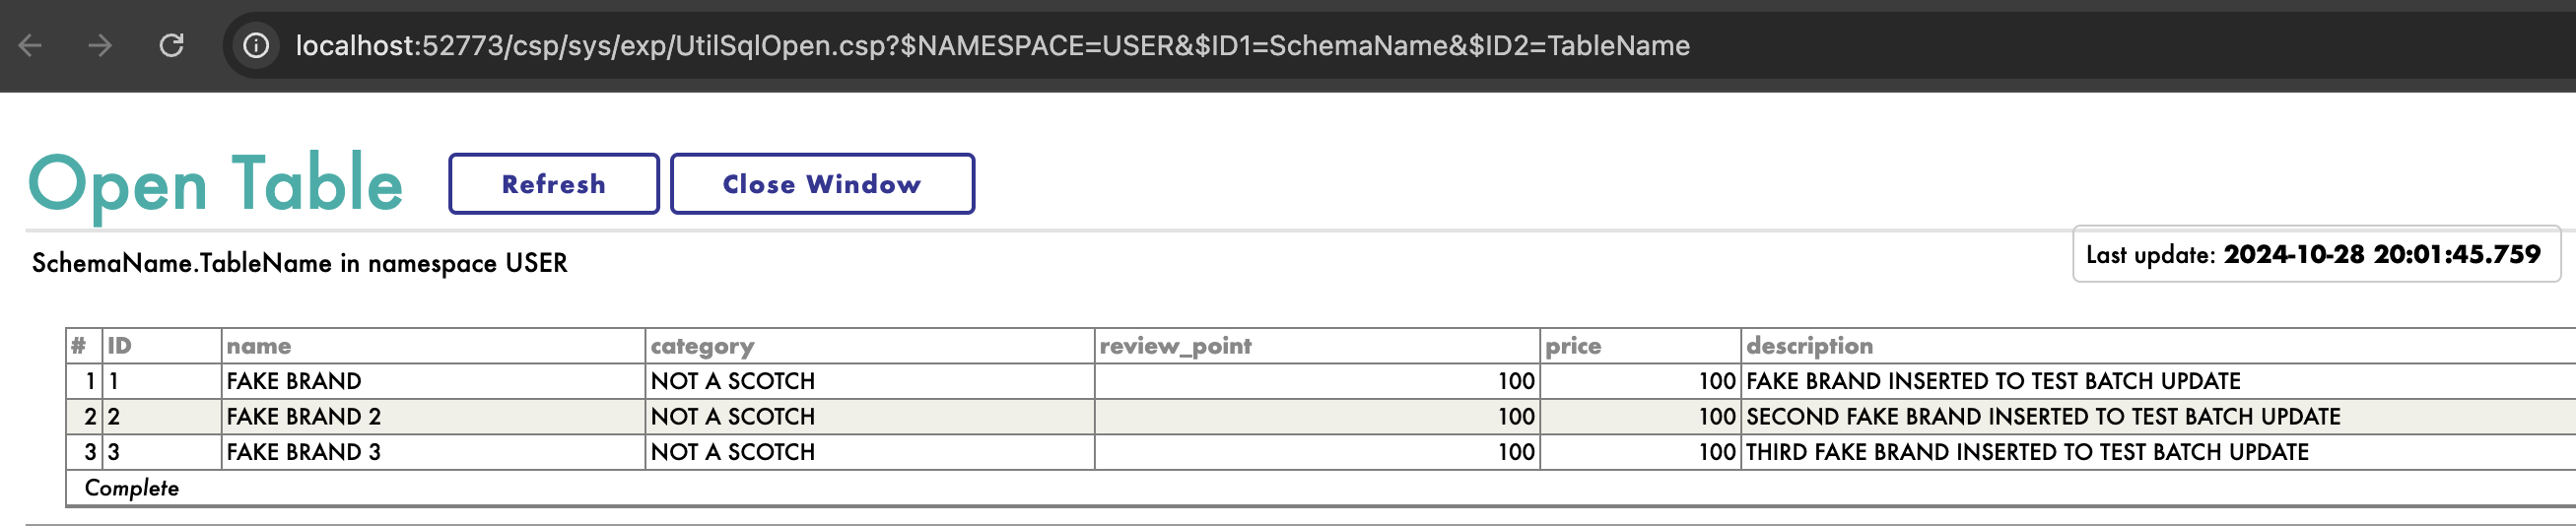

## Deleting rows

In [10]:
sql = f"DELETE FROM {tableName} WHERE ID = 1"
cursor.execute(sql) 

1

We see that the above statement deletes row 1 as can be seen from the final table:

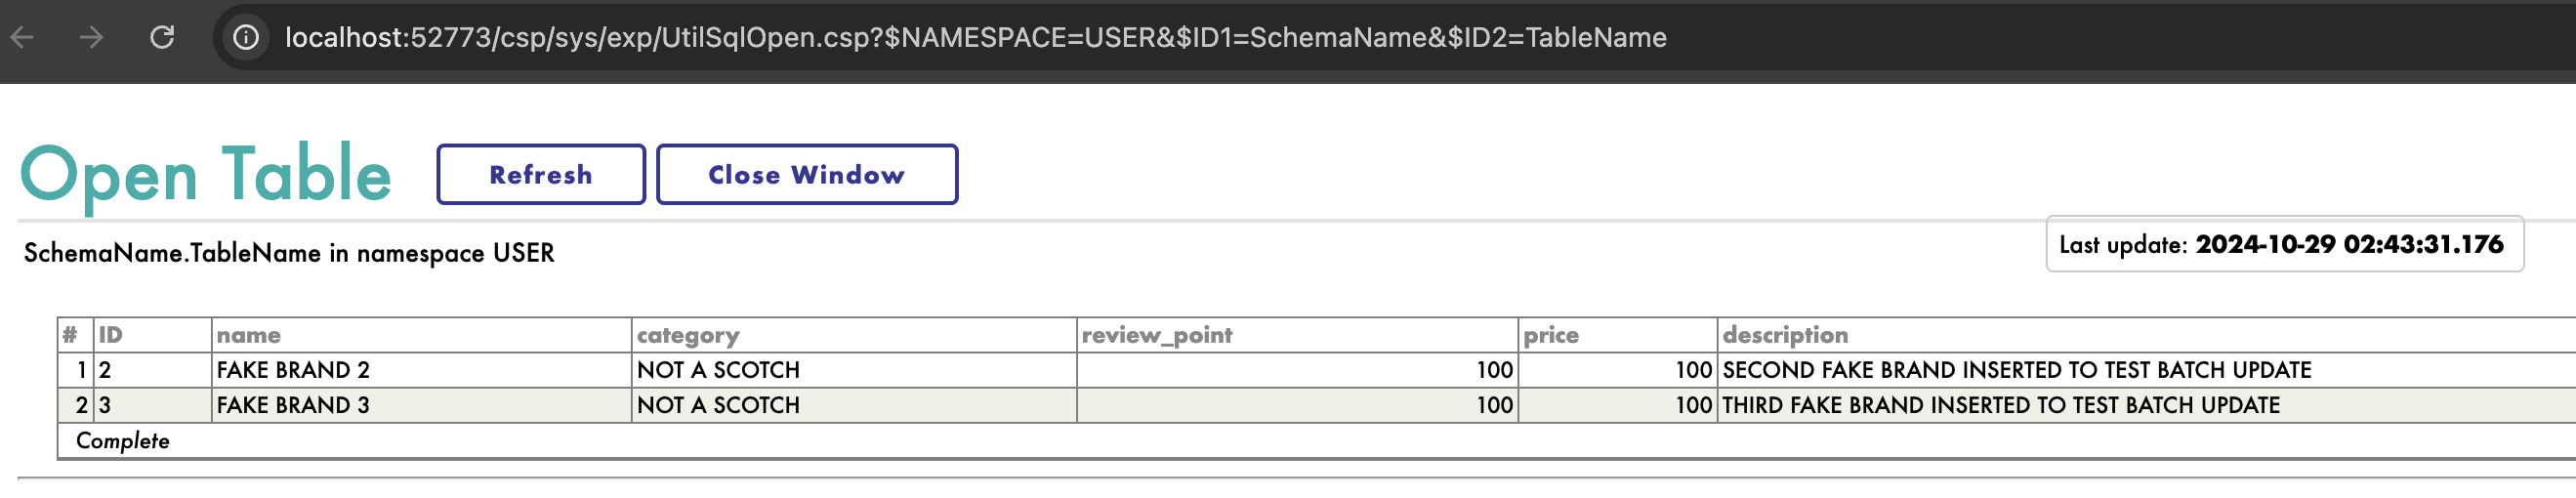

## Delete entire table

In [11]:
try:
    cursor.execute(f"DROP TABLE {tableName}")  
except:
    pass

## Adding data one row at a time by looping over the dataframe

In [12]:
## create table as it was deleted in last step:
cursor.execute(f"CREATE TABLE {tableName} {tableDefinition}")

0

In [13]:
##looping through dataframe and adding all the data to IRIS table
sql = f"Insert into {tableName} (name, category, review_point, price, description) values (?,?,?,?,?)"
start_time = time.time()
for index,row in df.iterrows():
    data = [(row['name'], row['category'], row['review.point'], row['price'], row['description'])]
    cursor.execute(sql, data)
end_time = time.time()
print(f"time taken to add {len(df)} entries: {end_time-start_time} seconds")

time taken to add 2228 entries: 2.1078810691833496 seconds


## Reading from the table

In [14]:
## Read only select columns
cursor.execute(f"select name, category, price from {tableName}")
fetched_data = cursor.fetchmany(3)
for row in fetched_data:
    print(row)

('Johnnie Walker Blue Label, 40%', 'Blended Scotch Whisky', 225.0)
('Black Bowmore, 1964 vintage, 42 year old, 40.5%', 'Single Malt Scotch', 4500.0)
('Bowmore 46 year old (distilled 1964), 42.9%', 'Single Malt Scotch', 13500.0)


In [15]:
##fetching all columns from database
cursor.execute(f"select * from {tableName}")
fetched_data = cursor.fetchmany(3)
for row in fetched_data:
    print(row)

('Johnnie Walker Blue Label, 40%', 'Blended Scotch Whisky', 97, 225.0, "Magnificently powerful and intense. Caramels, dried peats, elegant cigar smoke, seeds scraped from vanilla beans, brand new pencils, peppercorn, coriander seeds, and star anise make for a deeply satisfying nosing experience. Silky caramels, bountiful fruits of ripe peach, stewed apple, orange pith, and pervasive smoke with elements of burnt tobacco. An abiding finish of smoke, dry spices, and banoffee pie sweetness. Close to perfection. Editor's Choice")
('Black Bowmore, 1964 vintage, 42 year old, 40.5%', 'Single Malt Scotch', 97, 4500.0, "What impresses me most is how this whisky evolves; it's incredibly complex. On the nose and palate, this is a thick, viscous, whisky with notes of sticky toffee, earthy oak, fig cake, roasted nuts, fallen fruit, pancake batter, black cherry, ripe peach, dark chocolate-covered espresso bean, polished leather, tobacco, a hint of wild game, and lingering, leafy damp kiln smoke. Flav

# Adding vector embeddings to the table

## Create embeddings for the descriptions and add to the dataframe

In [16]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model. This model's output vectors are of size 384
model = SentenceTransformer('all-MiniLM-L6-v2')

/Users/utkanuygur/Desktop/hackathon-2024/iris-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Generate embeddings for all descriptions at once. Batch processing makes it faster
embeddings = model.encode(df['description'].tolist(), normalize_embeddings=True)

# Add the embeddings to the DataFrame
df['description_vector'] = embeddings.tolist()

In [18]:
df.head()

,name,category,review.point,price,description,description_vector
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,"Magnificently powerful and intense. Caramels, ...","[-0.010494396090507507, 0.01472897082567215, 0..."
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,What impresses me most is how this whisky evol...,"[0.023181209340691566, -0.051230356097221375, ..."
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,There have been some legendary Bowmores from t...,"[0.04333322495222092, -0.017066674306988716, -..."
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,With a name inspired by a 1926 Buster Keaton m...,"[-0.0759400874376297, -0.036762356758117676, 0..."
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,"Captivating, enticing, and wonderfully charmin...","[-0.01281892042607069, -0.09769793599843979, 0..."


## Delete and create the table in IRIS again to add embeddings
### (Note: Alternately, the Alter Table command can be used to just add the new embeddings column : https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=RSQL_altertable#RSQL_altertable_synopsis )

In [19]:
try:
    cursor.execute(f"DROP TABLE {tableName}")  
except:
    pass


tableName = "SchemaName.TableName"

## note the additional description_vector VECTOR(DOUBLE, 384) field to store embeddings
tableDefinition = "(name VARCHAR(255), category VARCHAR(255),review_point INT, price DOUBLE, description VARCHAR(2000), description_vector VECTOR(DOUBLE, 384))"
cursor.execute(f"CREATE TABLE {tableName} {tableDefinition}")

0

## Add all the rows to the table in IRIS

### Adding the entire dataframe as a single batch (faster)

In [20]:
sql = f"""
    INSERT INTO {tableName}
    (name, category, review_point, price, description, description_vector) 
    VALUES (?, ?, ?, ?, ?, TO_VECTOR(?))
"""

start_time = time.time()
# Prepare the list of tuples (parameters for each row)
data = [
    (
        row['name'], 
        row['category'], 
        row['review.point'], 
        row['price'], 
        row['description'], 
        str(row['description_vector']) 
    )
    for index, row in df.iterrows()
]

cursor.executemany(sql, data)
end_time = time.time()
print(f"time taken to add {len(df)} entries: {end_time-start_time} seconds")

time taken to add 2228 entries: 1.5179388523101807 seconds


### Adding one row at a time (slower)

In [21]:
try:
    cursor.execute(f"DROP TABLE {tableName}")  
except:
    pass


tableName = "SchemaName.TableName"

## note the additional description_vector VECTOR(DOUBLE, 384) field to store embeddings
tableDefinition = "(name VARCHAR(255), category VARCHAR(255),review_point INT, price DOUBLE, description VARCHAR(2000), description_vector VECTOR(DOUBLE, 384))"
cursor.execute(f"CREATE TABLE {tableName} {tableDefinition}")

0

In [22]:
## note the TO_VECTOR(?) used to add vector data type to the table
## also note the "str" conversion of the embeddings from the dataframe before they are added to the table in IRIS
# sql = f"Insert into {tableName} (name, category, review_point, price, description, description_vector) values (?,?,?,?,?,TO_VECTOR(?))"
sql = f"""
    INSERT INTO {tableName}
    (name, category, review_point, price, description, description_vector) 
    VALUES (?, ?, ?, ?, ?, TO_VECTOR(?))
"""
start_time = time.time()
for index,row in df.iterrows():    
    data = [(row['name'], row['category'], row['review.point'], row['price'], row['description'], str(row['description_vector']) )]
    cursor.execute(sql, data)
end_time = time.time()
print(f"time taken to add {len(df)} entries: {end_time-start_time} seconds")

time taken to add 2228 entries: 5.745877027511597 seconds


# Using IRIS Vector Search

## Let's look for a scotch that costs less than $100, and has an earthy and creamy taste.

In [23]:
# This is our search phrase
searchPhrase = "earthy and creamy taste"

# Convert search phrase into a vector
searchVector = model.encode(searchPhrase, normalize_embeddings=True).tolist() 

In [24]:
# Define the SQL query with placeholders for the vector and limit
sql = f"""
    SELECT TOP ? name, category, price, description
    FROM {tableName}
    WHERE price < 100 
    ORDER BY VECTOR_DOT_PRODUCT(description_vector, TO_VECTOR(?)) DESC
"""

numberOfResults = 3

# Execute the query with the number of results and search vector as parameters
cursor.execute(sql, [numberOfResults, str(searchVector)])

# Fetch all results
results = cursor.fetchall()
for row in results:
    print(row)

('Signatory (distilled at Bowmore), 16 year old, 1988 vintage, cask #42508, 46%', 'Single Malt Scotch', 60.0, 'Medium-bodied and nicely textured. Good balance of flavors -- and well-integrated, too -- with lovely sweet notes (cereal grain, cookie dough, caramel, and vanilla cream), young heathery peat, tar, fishnets, and brine that is complementary, but not aggressive, with a suggestion of lavender and tangerine. Balanced finish. (332 bottles produced.)')
('Shieldaig 12 year old, 40%', 'Blended Scotch Whisky', 31.0, 'This is a sharp dresser, with a firm, solid mouthfeel and an altogether finer and more focused taste than Shieldaig Classic (see\r\nbelow). It’s not coastal or earthy particularly, either. Instead the flavors are softer and built around mocha, smooth creamy toffee, and some soft fruit, including a touch of overripe banana and melon notes. The savoriness this time comes from a touch of pepper rather than salt.')
('The Arran Malt, Single Bourbon Cask, (Cask#1801), 1996 Vinta